In [2]:
using Random, Distributions, Statistics

h = 0.1 #storage cost
c = 2.0 #unit profit
p = 0.50 #probability of delivery
K = 40 # fixed order cost
k = 1.0 # variable order cost
average_demand = 20

s = 30
S = 50 

X = 100  # first day of simulation
profit = 0.0 

0.0

In [3]:
pois = Poisson(average_demand)

Poisson{Float64}(λ=20.0)

In [4]:
methods(rand);
# multiple-dispatch

In [5]:
dump(pois)

Poisson{Float64}
  λ: Float64 20.0


In [8]:
using Random
using Distributions
using Statistics
# m - number of days
# s - reorder point
# S - target warehouse volume
function simulateOneRun(m, s, S;
    h = 0.1, #storage cost
    c = 4.0, #unit profit
    p = 0.50, #probability of delivery
    K = 100, # fixed order cost
    k = 1.0, # variable order cost
    init_S = 100, #initial warehouse level
    average_demand = 20)
    
    Xⱼ = init_S
    local Yj
    profit = 0
    lost_orders = 0
    warehouse_levels = Int[]
    pois = Distributions.Poisson(average_demand)
    for day in 1:m
        if Xⱼ < s  # reorder point
            if rand() < p
                # the order has arrived
                profit -= K + (S-Xⱼ)*k
                Xⱼ = S
            end
        end
        push!(warehouse_levels, Xⱼ)
        demand = rand(pois)
        sales = min(Xⱼ, demand)
        Xⱼ -= sales
        @assert Xⱼ >= 0
        lost_order = demand - sales # failed to provide
        @assert lost_order >= 0 
        profit += sales*c - Xⱼ*h  # storage costs
        lost_orders += lost_order
    end
    
    (; profit, lost_orders,  warehouse_levels )
end

simulateOneRun (generic function with 1 method)

In [9]:
res = simulateOneRun(50,50,200)

(profit = 1729.9999999999993, lost_orders = 89, warehouse_levels = [100, 79, 53, 200, 181, 162, 141, 123, 101, 87  …  24, 13, 0, 0, 0, 200, 173, 149, 132, 113])

In [10]:
Random.seed!(10)
res = simulateOneRun(30,50,200)

res.warehouse_levels'


1×30 adjoint(::Vector{Int64}) with eltype Int64:
 100  79  60  200  184  158  136  122  99  …  175  155  143  122  100  84  64

res.profit = 1764.3999999999996


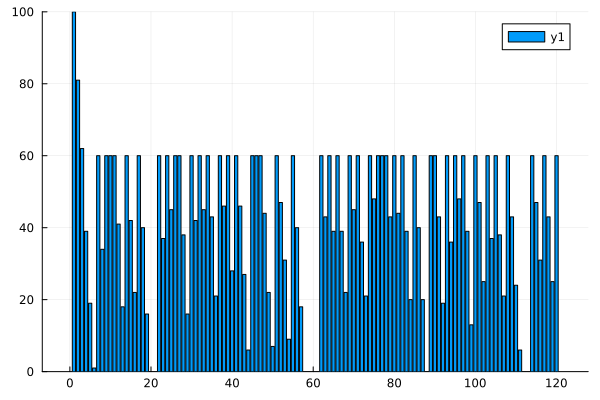

In [11]:
using Plots
res = simulateOneRun(120,40,60)
#plot(res.warehouse_levels)
@show res.profit
Plots.bar(1:length(res.warehouse_levels), res.warehouse_levels)


In [12]:
dump(res)

@NamedTuple{profit::Float64, lost_orders::Int64, warehouse_levels::Vector{Int64}}
  profit: Float64 1764.3999999999996
  lost_orders: Int64 322
  warehouse_levels: Array{Int64}((120,)) [100, 81, 62, 39, 19, 1, 60, 34, 60, 60  …  6, 0, 0, 60, 47, 31, 60, 43, 25, 60]


In [13]:
using DataFrames
df = DataFrame( simulateOneRun(10,20,40) for _ in 1:10  )

Row,profit,lost_orders,warehouse_levels
,Float64,Int64,Array…
1,301.2,71,"[100, 72, 54, 35, 13, 0, 0, 0, 40, 40]"
2,395.5,74,"[100, 79, 69, 41, 15, 40, 29, 12, 0, 0]"
3,244.6,20,"[100, 82, 61, 40, 23, 40, 23, 1, 40, 40]"
4,362.3,94,"[100, 80, 64, 47, 17, 0, 0, 0, 0, 40]"
5,394.2,38,"[100, 81, 57, 42, 26, 13, 40, 24, 15, 0]"
6,387.2,15,"[100, 83, 67, 35, 10, 40, 15, 40, 40, 22]"
7,369.4,48,"[100, 78, 56, 33, 40, 22, 8, 0, 40, 13]"
8,327.8,42,"[100, 79, 65, 45, 27, 0, 0, 40, 24, 40]"
9,326.8,1,"[100, 78, 59, 45, 27, 40, 20, 40, 25, 40]"


In [14]:
mean(df.profit), std(df.profit)

(348.25000000000006, 48.28006835123579)

In [15]:

function run_sims(m,s,S,N=100; kwargs...)
    df = DataFrame(simulateOneRun(m,s,S; kwargs...) for _ in 1:N)
    (
        m=m,
        s=s,
        S=S,
        N=N,
        profit_mean = mean(df.profit),
        profit_std = std(df.profit),
        lost_mean = mean(df.lost_orders),
        lost_std = std(df.lost_orders),
        kwargs...
    )
end


run_sims(30,50,100,1000, k=2, c=4)

(m = 30, s = 50, S = 100, N = 1000, profit_mean = 396.70570000000004, profit_std = 114.64024198593002, lost_mean = 35.492, lost_std = 38.115597000896294, k = 2, c = 4)

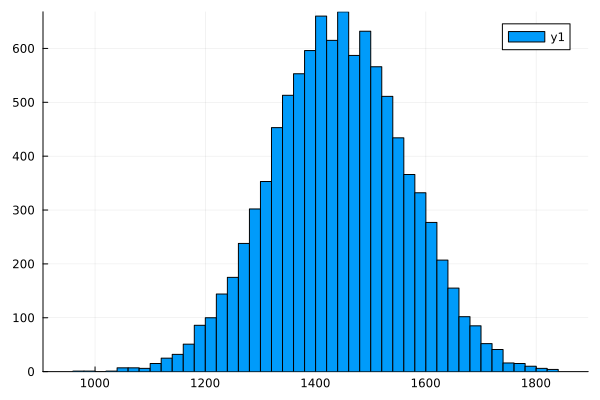

In [18]:
df = DataFrame(simulateOneRun(50,50,100) for _ in 1:10_000)
histogram(df.profit, bins=50)


In [19]:
@time run_sims(30,50,100,1000)

  0.069391 seconds (40.31 k allocations: 2.749 MiB, 94.94% compilation time)


(m = 30, s = 50, S = 100, N = 1000, profit_mean = 917.6067999999999, profit_std = 100.1141930267902, lost_mean = 35.457, lost_std = 39.0675879397158)

In [20]:
df = DataFrame( run_sims(90,s,S,1000) for s in 20:10:250, 
                S in 50:50:500 if s < S )

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,90,20,50,1000,1218.42,95.9245,437.877,100.073
2,90,30,50,1000,833.213,150.967,377.31,99.479
3,90,40,50,1000,42.9756,291.632,327.3,98.2722
4,90,20,100,1000,2826.56,168.607,245.979,84.3175
5,90,30,100,1000,2792.5,155.553,195.92,84.2058
6,90,40,100,1000,2679.62,140.682,150.243,76.6879
7,90,50,100,1000,2500.87,152.906,118.115,68.8287
8,90,60,100,1000,2209.98,175.919,95.963,61.6789
9,90,70,100,1000,1811.54,226.885,81.715,64.3258


In [22]:
best_row = argmax(df.profit_mean)

26

In [23]:
df[best_row,:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
26,90,30,200,1000,3415.71,180.637,99.013,64.4793


In [24]:
less500 = findall(<=(500), df.profit_mean)

7-element Vector{Int64}:
  3
 11
 24
 41
 42
 64
 65

In [25]:
df[findall(<=(500), df.profit_mean), :]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,90,40,50,1000,42.9756,291.632,327.3,98.2722
2,90,90,100,1000,267.057,436.293,59.376,55.3675
3,90,140,150,1000,-96.2379,501.027,9.207,21.7933
4,90,180,200,1000,417.302,392.784,2.68,11.6838
5,90,190,200,1000,-562.827,536.717,2.436,10.6611
6,90,230,250,1000,-68.1954,405.69,0.928,7.06744
7,90,240,250,1000,-1039.8,550.467,0.925,6.62263


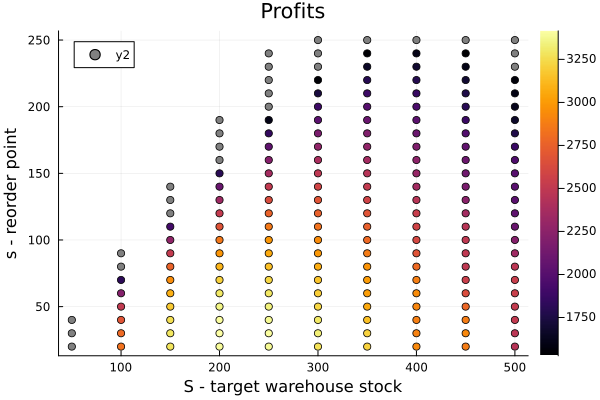

In [30]:

more500 = findall(>(1500), df.profit_mean)

scatter(df.S[more500], df.s[more500], zcolor=df.profit_mean[more500], label="",
        xlabel="S - target warehouse stock", ylabel="s - reorder point", title="Profits")

scatter!(df.S[Not(more500)],
        df.s[Not(more500)], 
        color=colorant"gray")


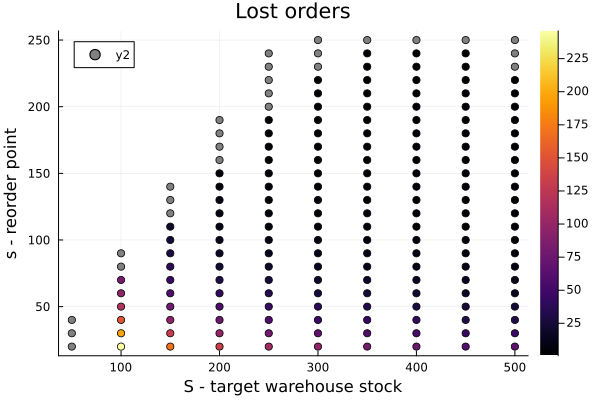

In [31]:



scatter(df.S[more500], df.s[more500], zcolor=df.lost_mean[more500], label="",
        xlabel="S - target warehouse stock", ylabel="s - reorder point", title="Lost orders")

scatter!(df.S[Not(more500)],
        df.s[Not(more500)], 
        color=colorant"gray")


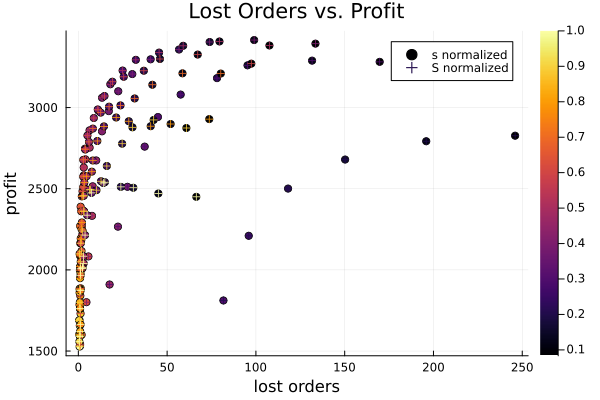

In [32]:
normalized_s = df.s[more500] ./ maximum(df.s[more500])
normalized_S = df.S[more500] ./ maximum(df.S[more500])

scatter(df.lost_mean[more500], df.profit_mean[more500], 
        zcolor=normalized_s, marker=:circle, label="s normalized",
        xlabel="lost orders", ylabel="profit", title="Lost Orders vs. Profit")

scatter!(df.lost_mean[more500], df.profit_mean[more500], 
         zcolor=normalized_S, marker=:cross, label="S normalized")